In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import json
import gc

import cv2
import keras
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [ ]:


train_df = pd.read_csv('/content/drive/My Drive/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()



(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [ ]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [ ]:


sub_df = pd.read_csv('/content/drive/My Drive/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
test_imgs.head()



,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [ ]:


non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
non_missing_train_idx.head()



,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [ ]:
def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 256))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)



In [ ]:
BATCH_SIZE = 64
def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory='/content/drive/My Drive/Colab Notebooks/test_images',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

test_gen = create_test_gen()

Found 1801 validated image filenames.


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/drive/My Drive/Colab Notebooks/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [ ]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,  # NOTICE DIFFERENCE
    random_state=2019, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [ ]:
model = build_model((256, 1600, 1))
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]            

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [ ]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=10
)

Epoch 1/10
354/354 [==============================] - 572s 2s/step - loss: 0.0371 - dice_coef: 0.0387 - val_loss: 0.0354 - val_dice_coef: 0.0498
Epoch 2/10
354/354 [==============================] - 179s 506ms/step - loss: 0.0343 - dice_coef: 0.0645 - val_loss: 0.0323 - val_dice_coef: 0.0805
Epoch 3/10
354/354 [==============================] - 185s 524ms/step - loss: 0.0297 - dice_coef: 0.1510 - val_loss: 0.0281 - val_dice_coef: 0.1910
Epoch 4/10
354/354 [==============================] - 186s 525ms/step - loss: 0.0263 - dice_coef: 0.2137 - val_loss: 0.0294 - val_dice_coef: 0.1397
Epoch 5/10
354/354 [==============================] - 179s 505ms/step - loss: 0.0246 - dice_coef: 0.2553 - val_loss: 0.0227 - val_dice_coef: 0.3101
Epoch 6/10
354/354 [==============================] - 178s 502ms/step - loss: 0.0225 - dice_coef: 0.3002 - val_loss: 0.0218 - val_dice_coef: 0.3299
Epoch 7/10
354/354 [==============================] - 180s 508ms/step - loss: 0.0217 - dice_coef: 0.3230 - val_loss

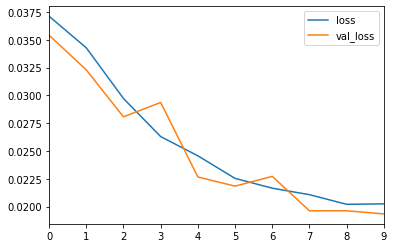

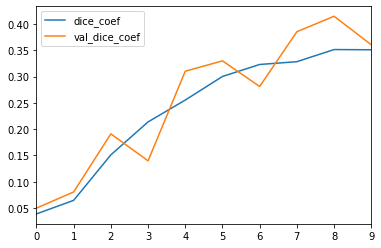

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
remove_model = load_model('/content/drive/My Drive/Colab Notebooks/model (2).h5')
remove_model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      


In [ ]:
test_missing_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

test_imgs['allMissing'] = test_missing_pred
test_imgs.head()


29/29 [==============================] - 507s 17s/step


,ImageId,allMissing
0,004f40c73.jpg,0.535308
1,006f39c41.jpg,0.999956
2,00b7fb703.jpg,0.997788
3,00bbcd9af.jpg,0.000324
4,0108ce457.jpg,0.114875


In [ ]:
filtered_test_imgs = test_imgs[test_imgs['allMissing'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(721, 2)


,ImageId,allMissing
3,00bbcd9af.jpg,0.000324
4,0108ce457.jpg,0.114875
6,010ec96b4.jpg,0.000624
8,017bd7ce3.jpg,0.042616
9,01b47d973.jpg,0.022378


In [ ]:
filtered_mask = sub_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
filtered_sub_df = sub_df[filtered_mask].copy()
null_sub_df = sub_df[~filtered_mask].copy()
null_sub_df['EncodedPixels'] = null_sub_df['EncodedPixels'].apply(
    lambda x: ' ')

filtered_sub_df.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(filtered_sub_df.shape)
print(null_sub_df.shape)

filtered_sub_df.head()

(2884, 3)
(4320, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,1 1,00bbcd9af.jpg
1,00bbcd9af.jpg_2,1 1,00bbcd9af.jpg
2,00bbcd9af.jpg_3,1 1,00bbcd9af.jpg
3,00bbcd9af.jpg_4,1 1,00bbcd9af.jpg
4,0108ce457.jpg_1,1 1,0108ce457.jpg


In [ ]:
model.load_weights('/content/model.h5')
test_df = []

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='/content/drive/My Drive/Colab Notebooks/test_images',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

300/300 [==============================] - 5s 16ms/step


300it [00:05, 51.33it/s]

 11/300 [>.............................] - ETA: 3s

300/300 [==============================] - 4s 12ms/step


300it [00:06, 49.81it/s]


121/121 [==============================] - 2s 13ms/step


121it [00:02, 48.58it/s]


In [ ]:
test_df = pd.concat(test_df)
print(test_df.shape)
test_df.head()

(2884, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,156107 1 156109 1 156111 1 156113 39 156352 1 ...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,0108ce457.jpg_1,,0108ce457.jpg


In [ ]:
final_submission_df = pd.concat([test_df, null_sub_df])
print(final_submission_df.shape)
final_submission_df.head()

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,156107 1 156109 1 156111 1 156113 39 156352 1 ...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,0108ce457.jpg_1,,0108ce457.jpg


In [ ]:
final_submission_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('submission.csv', index=False)

In [ ]:
test_df

,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,156107 1 156109 1 156111 1 156113 39 156352 1 ...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,0108ce457.jpg_1,,0108ce457.jpg
...,...,...,...
2879,ffc9a6187.jpg_4,,ffc9a6187.jpg
2880,ffdb60677.jpg_1,,ffdb60677.jpg
2881,ffdb60677.jpg_2,,ffdb60677.jpg
2882,ffdb60677.jpg_3,338227 1 338482 5 338737 8 338992 10 339248 10...,ffdb60677.jpg


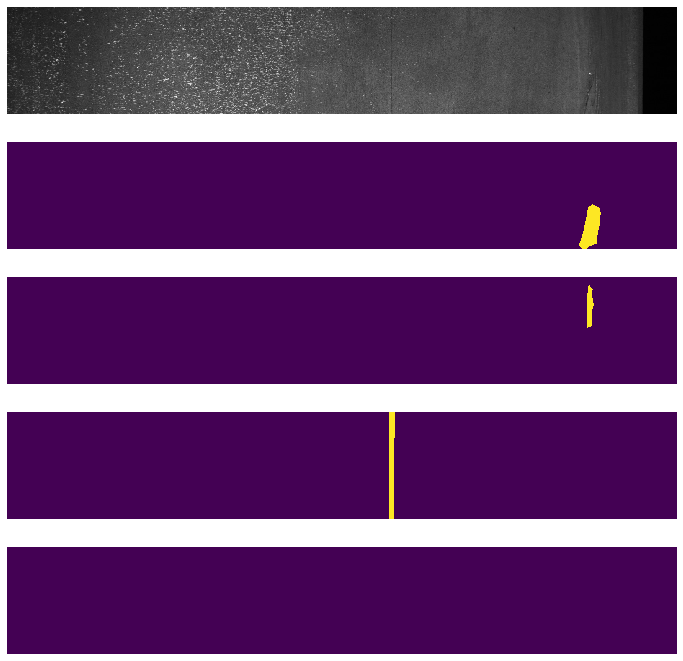

In [ ]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"/content/drive/My Drive/Colab Notebooks/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

In [ ]:
#model.h5-->enoded pixel-->dataframe-->this code(dont trash the function)

sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"/content/drive/My Drive/Colab Notebooks/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')